# **Number classification algorithm**

# Read database

Functions used to read the database (train and test) from MNIST and also from the csv file generated with the images captured from the pico camera

In [9]:
import os
import csv
import numpy as np
import matplotlib.pyplot as plt
import itertools

from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.grid_search import RandomizedSearchCV
from sklearn.grid_search import GridSearchCV

In [10]:
class Digit:
    def __init__(self, data, target):
        self.target = target
        self.width  = int(np.sqrt(len(data)))
        self.image  = data.reshape(self.width, self.width)
        self.features = {'var' : 0,
                         'std' : 0,
                         'mean_grad_M' : 0,
                         'std_grad_M'  : 0,
                         'mean_grad_D' : 0,
                         'std_grad_D'  : 0,
                         'mean_PC_X'   : 0,
                         'std_PC_X'    : 0,
                         'active_PC_X' : 0,
                         'mean_PC_Y'   : 0,
                         'std_PC_Y'    : 0,
                         'active_PC_Y' : 0}
        self.computeFeatures()
    
    def computeFeatures(self):
        # Feature computation
        mag, ang = sobel(self.image)
        pcx, pcy = pixel_count(self.image)
        
        self.features['var'] = np.var(self.image)
        self.features['std'] = np.std(self.image)
        self.features['mean_grad_M'] = np.mean(mag)
        self.features['std_grad_M'] =  np.std(mag)
        self.features['mean_grad_D'] = np.mean(ang)
        self.features['std_grad_D'] =  np.std(ang)
        self.features['mean_PC_X'] =   np.mean(pcx)
        self.features['std_PC_X'] =    np.std(pcx)
        self.features['active_PC_X'] = np.count_nonzero(pcx)
        self.features['mean_PC_Y'] =   np.mean(pcy)
        self.features['std_PC_Y'] =    np.std(pcy)
        self.features['active_PC_Y'] = np.count_nonzero(pcy) 
  
    def __print__(self):
        print("Digit target: "+str(self.target))
        print("Digit features:")
        print(self.features)
        print("Digit image:")
        plt.gray()
        plt.matshow(self.image) 
        plt.show()

In [11]:
def sobel(image):
    w = len(image)
    kernel_x = np.array([ [ 1, 0,-1],
                          [ 2, 0,-2],
                          [ 1, 0,-1] ])

    kernel_y = np.array([ [ 1, 2, 1],
                          [ 0, 0, 0],
                          [-1,-2,-1] ])
    
    grad_x = np.zeros([w - 2, w - 2])
    grad_y = np.zeros([w - 2, w - 2])
    
    for i in range(w - 2):
        for j in range(w - 2):
            grad_x[i, j] = sum(sum(image[i : i + 3, j : j + 3] * kernel_x))
            grad_y[i, j] = sum(sum(image[i : i + 3, j : j + 3] * kernel_y))
            if grad_x[i, j] == 0:
                grad_x[i, j] = 0.000001 
    
    mag = np.sqrt(grad_y ** 2 + grad_x ** 2)
    ang = np.arctan(grad_y / (grad_x + np.finfo(float).eps))
  
    # Gradient computation
  
    return [mag,ang]

def pixel_count(image):
    pc_x = np.zeros(len(image))
    pc_y = np.zeros(len(image))
  
    # Pixel count computation
    for i in range(len(image)):
        pc_x[i] = np.count_nonzero(image[i, :])
        pc_y[i] = np.count_nonzero(image[:, i])

    return [pc_x, pc_y]

In [12]:
class Dataset:
    def __init__(self, array, length):  
        self.array = array
        self.length = length
        self.digits = []
        self.digits = self.createDigits()
        self.raw_features = [[float(f) for f in dig.features.values()] for dig in self.digits]
        self.raw_targets  = [[self.digits[i].target] for i in range(self.length)]
  
    def createDigits(self):
        digits = []
        for row in self.array:
            digits.append(Digit(np.array(row[:-1]), row[-1]))
        return digits

# Generate datasets

In [13]:
# n : percent of the number of lines in the data base use as array set
def load_data_set(array, n):
    dataset = Dataset(array[:int(n * len(array))], int(n * len(array)))
    return dataset

In [14]:
%%time

#Load the database (.npy) files 
img_array_train = np.load('./../train.npy')
img_array_test = np.load('./../test.npy')
img_array_validation = np.load('./../validation.npy')

CPU times: user 920 µs, sys: 282 ms, total: 283 ms
Wall time: 282 ms


In [15]:
%%time 

print("Creating train dataset...")
print("Number of the lines in the train dataset: " + str(len(img_array_train))) 
training_set = load_data_set(img_array_train, 0.1)
print("Number of the lines in the train set: " + str(training_set.length))
print ("\nFinished creating train dataset\n")

Creating train dataset...
Number of the lines in the train dataset: 120000
Number of the lines in the train set: 12000

Finished creating train dataset

CPU times: user 2min 21s, sys: 353 ms, total: 2min 21s
Wall time: 2min 21s


In [16]:
%%time 

print("Creating testing dataset")
print("Number of the lines in the test dataset: " + str(len(img_array_test)))
testing_set = load_data_set(img_array_test, 0.1)
print ("Number of the lines in the test dataset: " + str(testing_set.length))
print ("\nFinished creating test dataset\n")

Creating testing dataset
Number of the lines in the test dataset: 15375
Number of the lines in the test dataset: 1537

Finished creating test dataset

CPU times: user 18.4 s, sys: 64 ms, total: 18.5 s
Wall time: 18.5 s


In [17]:
%%time 

    
print("Creating validation dataset...")
print("Number of the lines in the validation dataset: " + str(len(img_array_validation)))
validation_set = load_data_set(img_array_validation, 0.1)
print ("Number of the lines in the validation dataset: " + str(validation_set.length))
print ("\nFinished creating validation dataset\n")

Creating validation dataset...
Number of the lines in the validation dataset: 5125
Number of the lines in the validation dataset: 512

Finished creating validation dataset

CPU times: user 6.28 s, sys: 12 ms, total: 6.29 s
Wall time: 6.29 s


In [57]:
'''
for i in range(0,5):
    validation_set.digits[i].__print__()
'''

'\nfor i in range(0,5):\n    validation_set.digits[i].__print__()\n'

In [18]:
def cvt_obj_nparray(dataset):
    X = np.zeros((dataset.length, 12))
    Y = np.zeros((dataset.length,))
    for i, digit in enumerate(dataset.digits):
        Y[i] = digit.target
        for j, feature in enumerate(digit.features):
            X[i, j] = digit.features[feature]
    return X, Y

In [19]:
%%time

#The X_dataset and Y_dataset are the lists used in the classifier
print("Creating X_dataset and Y_dataset")
X_train, Y_train = cvt_obj_nparray(training_set)
X_test, Y_test = cvt_obj_nparray(testing_set)
X_validation, Y_validation = cvt_obj_nparray(validation_set)
print("Finished X_dataset and Y_dataset\n")

Creating X_dataset and Y_dataset
Finished X_dataset and Y_dataset

CPU times: user 63.8 ms, sys: 12 ms, total: 75.8 ms
Wall time: 64.6 ms


# **KK Neighborhod algorithm**

In [20]:
def plot_confusion_matrix(clf, data_x, data_y):
    classes = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z']

    Ypred = clf.predict(data_x)
    
    # Computation of confusion matrix on testing set
    cm = confusion_matrix(data_y, Ypred)
    
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('Confusion matrix')
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    #plt.figure(figsize=(20,10))

    fmt = 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

In [16]:
def train_knnModel(i):  
    #Train the classifier
    print("Training KNN classifier...")
    clf = KNeighborsClassifier(n_neighbors=i)
    print("Finished trainning KNN classifier with " + str(i) + " neighbors")
    
    # Training KNN
    return clf.fit(X_train, Y_train)

knn_classificator = train_knnModel(5)

Training KNN classifier...
Finished trainning KNN classifier with 5 neighbors


The accuracy for test database is: 36.35%
Using: 12000 images


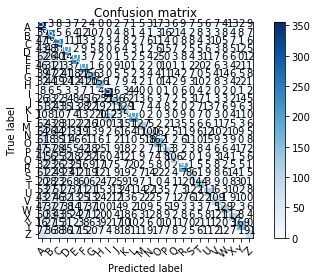

In [21]:
# Compute prediction accuracy on training set
def train_knnModel2():
    predicted = knn_classificator.predict(X_train)
    print("The accuracy for test database is: " + str(round((accuracy_score(Y_train, predicted) * 100), 3)) + "%")

    print("Using: " + str(len(X_train)) + " images")
    
    plot_confusion_matrix(knn_classificator, X_train, Y_train)
    plt.show()

train_knnModel2()

The accuracy for test database is: 10.54%
Using: 1537 images


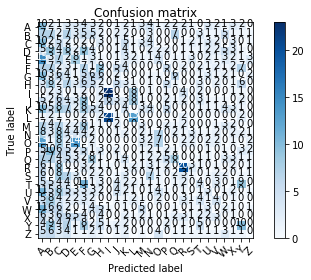

In [22]:
# Compute prediction accuracy on testing set
def test_knnModel():
    predicted = knn_classificator.predict(X_test)
    print("The accuracy for test database is: " + str(round((accuracy_score(Y_test, predicted) * 100), 3)) + "%")

    print("Using: " + str(len(X_test)) + " images")
    
    plot_confusion_matrix(knn_classificator, X_test, Y_test)
    plt.show()

test_knnModel()

# Save classifier

In [3]:
import cPickle

In [20]:
# save the classifier
with open('knnClassifier.pkl', 'wb') as f:
    cPickle.dump(knn_classificator, f)    

In [6]:
# load it again
with open('knnClassifier.pkl', 'rb') as f:
    knn_classificator = cPickle.load(f)

In [7]:
knn_classificator

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform')

# **Evaluation methods**

This part contains the functions used to analyse the accuracy of the classifier

# **Multiple Hyperparameter Study**
This part consist in making a study of the hyperparameter of the classifier, using the gridsearch method from the scikitlearn library.

In [15]:
# Define the parameter values that should be searched
k_range = list(range(1, 30))

# Another parameter besides k that we might vary is the weights parameters or even the algorithm
weight_options = ['uniform', 'distance']
#algorithm_options = ['auto', 'ball_tree', 'kd_tree', 'brute']

# Specify "parameter grid"
param_grid = dict(n_neighbors=k_range, weights=weight_options)

# Specify "parameter distributions" rather than a "parameter grid"
param_dist = dict(n_neighbors=k_range, weights=weight_options)

# Since both parameters are discrete, so param_dist is the same as param_grid

# Finally define the classifier, in this case the KNN classifier
knn = KNeighborsClassifier()

In [16]:
%%time

grid_best_scores = []
grid_best_params = []
grid_best_estimator = []

rand_best_scores = []
rand_best_params = []
rand_best_estimator = []

for _ in list(range(20)):
    grid = GridSearchCV(knn, param_grid, cv=10, scoring='accuracy', n_jobs = -1)
    grid.fit(X_train, Y_train)
    grid_best_scores.append(grid.best_score_)
    grid_best_params.append(grid.best_params_)
    grid_best_estimator.append(grid.best_estimator_)

    rand = RandomizedSearchCV(knn, param_dist, cv=10, scoring='accuracy', n_iter=10, n_jobs = -1)
    rand.fit(X_train, Y_train)
    rand_best_scores.append(rand.best_score_)
    rand_best_params.append(rand.best_params_)
    rand_best_estimator.append(rand.best_estimator_)
    
print("Finished searching the hyper parameters!")


Finished searching the hyper parameters!
CPU times: user 43.9 s, sys: 3.9 s, total: 47.9 s
Wall time: 7min 56s


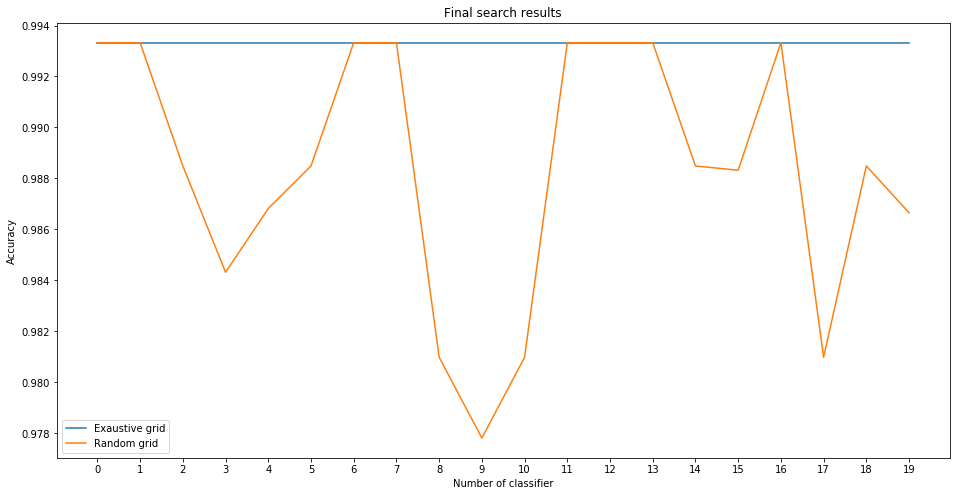

GRID SEARCH RESULTS
The best accuracy is: 99.3326659993%
The parameters is: {'n_neighbors': 1, 'weights': 'uniform'}


RANDOMGRID SEARCH RESULTS
The best accuracy is: 99.3326659993%
The parameters is: {'n_neighbors': 1, 'weights': 'uniform'}


In [17]:
# This block draw accuracies of the differents classifiers used in the grid and random search

plt.figure(figsize=(16, 8))
plt.title("Final search results")   
plt.plot(range(len(grid_best_scores)), grid_best_scores, label = 'Exaustive grid')
plt.plot(range(len(rand_best_scores)), rand_best_scores, label = 'Random grid')
plt.xlabel('Number of classifier')
plt.ylabel('Accuracy')
plt.legend()
plt.xticks(range(len(grid_best_scores)))
plt.show()

print("GRID SEARCH RESULTS")
print("The best accuracy is: " + str(np.max(grid_best_scores) * 100) + "%")
print("The parameters is: " + str(grid_best_params[np.argmax(grid_best_scores)]))
print('\n')
print("RANDOMGRID SEARCH RESULTS")
print("The best accuracy is: " + str(np.max(rand_best_scores) * 100) + "%")
print("The parameters is: " + str(rand_best_params[np.argmax(rand_best_scores)]))

# Best KNN classificator

In [18]:
#Train the best classificator for a N sample of numbers
def train_best_classifier():   
    classificator = rand_best_estimator[np.argmax(rand_best_scores)]

    return classificator.fit(X_train, Y_train)

In [19]:
#Testing this new classificator accuracy with MNIST database 
def validation_database(clf):
    predicted = clf.predict(X_validation)
    
    print("The accuracy for validation database is: " + str(round((accuracy_score(Y_validation, predicted) * 100), 3)) + "%")
    print("Using: " + str(len(X_train)) + " images to train")
    print("Using: " + str(len(X_test)) + " images to test")
    print("Using: " + str(len(X_validation)) + " images to validate")

    plot_confusion_matrix(clf, X_validation, Y_validation)



In [20]:
best_knn_classificator = train_best_classifier()

The accuracy for validation database is: 56.944%
Using: 5994 images to train
Using: 4662 images to test
Using: 2664 images to validate


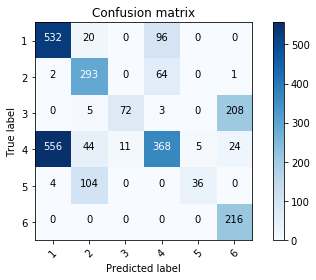

In [21]:
validation_database(best_knn_classificator)